## Example of online analysis using OnACID

Complete pipeline for online processing using CaImAn Online (OnACID).
The demo demonstates the analysis of a sequence of files using the CaImAn online
algorithm. The steps include i) motion correction, ii) tracking current 
components, iii) detecting new components, iv) updating of spatial footprints.
The script demonstrates how to construct and use the params and online_cnmf
objects required for the analysis, and presents the various parameters that
can be passed as options. A plot of the processing time for the various steps
of the algorithm is also included.
@author: Eftychios Pnevmatikakis @epnev
Special thanks to Andreas Tolias and his lab at Baylor College of Medicine
for sharing the data used in this demo.

In [1]:
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

from IPython.display import display, clear_output
import glob
import logging
import numpy as np
import os
import scipy
import cv2

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

import caiman as cm
from caiman.source_extraction import cnmf as cnmf
from caiman.paths import caiman_datadir
from caiman.utils.utils import download_demo
import matplotlib.pyplot as plt

import bokeh.plotting as bpl
try:
       from bokeh.io import vform, hplot
except:
       # newer version of bokeh does not use vform & hplot, instead uses column & row
       from bokeh.layouts import column as vform
       from bokeh.layouts import row as hplot
from bokeh.models import CustomJS, ColumnDataSource, Slider

bpl.output_notebook()

Loading BokehJS ...

## First download the data

The function ```download_demo``` will look for the datasets ```Tolias_mesoscope_*.hdf5``` inside the folder specified by the variable ```fld_name``` and will download the files if they do not exist. Note that you must be in the main CaImAn folder to run this demo

In [2]:
fld_name = 'Mesoscope'                              # folder inside ./example_movies where files will be saved
download_demo('Tolias_mesoscope_1.hdf5',fld_name)
download_demo('Tolias_mesoscope_2.hdf5',fld_name)
download_demo('Tolias_mesoscope_3.hdf5',fld_name)

folder_name = os.path.join(caiman_datadir(), 'example_movies', fld_name) # folder where files are located
extension = 'hdf5'                                  # extension of files
fnames = glob.glob(folder_name + '/*' + extension)       # read all files to be processed 

print(fnames)                                          # your list of files should look something like this

       23506 [utils.py:       download_demo():93] [7035] File Tolias_mesoscope_1.hdf5 already downloaded
       23508 [utils.py:       download_demo():93] [7035] File Tolias_mesoscope_2.hdf5 already downloaded
       23511 [utils.py:       download_demo():93] [7035] File Tolias_mesoscope_3.hdf5 already downloaded


['/mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_1.hdf5', '/mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_2.hdf5', '/mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_3.hdf5']


## Set up some parameters

Here we set up some parameters for running OnACID. We use the same `params` object as in batch processing with CNMF.

In [3]:
fr = 15                                                             # frame rate (Hz)
decay_time = 0.5                                                    # approximate length of transient event in seconds
gSig = (4,4)                                                        # expected half size of neurons
p = 1                                                               # order of AR indicator dynamics
min_SNR = 1                                                         # minimum SNR for accepting new components
rval_thr = 0.90                                                     # correlation threshold for new component inclusion
ds_factor = 1                                                       # spatial downsampling factor (increases speed but may lose some fine structure)
gnb = 2                                                             # number of background components
gSig = tuple(np.ceil(np.array(gSig)/ds_factor).astype('int'))       # recompute gSig if downsampling is involved
mot_corr = True                                                     # flag for online motion correction 
pw_rigid = False                                                    # flag for pw-rigid motion correction (slower but potentially more accurate)
max_shifts_online = np.ceil(10./ds_factor).astype('int')            # maximum allowed shift during motion correction
sniper_mode = True                                                  # flag using a CNN to detect new neurons (o/w space correlation is used)
init_batch = 200                                                    # number of frames for initialization (presumably from the first file)
expected_comps = 500                                                # maximum number of expected components used for memory pre-allocation (exaggerate here)
dist_shape_update = True                                            # flag for updating shapes in a distributed way
min_num_trial = 10                                                  # number of candidate components per frame     
K = 2                                                               # initial number of components
epochs = 2                                                          # number of passes over the data
show_movie = False                                                  # show the movie with the results as the data gets processed

params_dict = {'fnames': fnames,
               'fr': fr,
               'decay_time': decay_time,
               'gSig': gSig,
               'p': p,
               'min_SNR': min_SNR,
               'rval_thr': rval_thr,
               'ds_factor': ds_factor,
               'nb': gnb,
               'motion_correct': mot_corr,
               'init_batch': init_batch,
               'init_method': 'bare',
               'normalize': True,
               'expected_comps': expected_comps,
               'sniper_mode': sniper_mode,
               'dist_shape_update' : dist_shape_update,
               'min_num_trial': min_num_trial,
               'K': K,
               'epochs': epochs,
               'max_shifts_online': max_shifts_online,
               'pw_rigid': pw_rigid,
               'show_movie': show_movie}
opts = cnmf.params.CNMFParams(params_dict=params_dict)

       23567 [params.py:                 set():778] [7035] Changing key fnames in group data from None to ['/mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_1.hdf5', '/mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_2.hdf5', '/mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_3.hdf5']
       23569 [params.py:                 set():778] [7035] Changing key fr in group data from 30 to 15
       23570 [params.py:                 set():778] [7035] Changing key decay_time in group data from 0.4 to 0.5
       23571 [params.py:                 set():778] [7035] Changing key p in group preprocess from 2 to 1
       23572 [params.py:                 set():778] [7035] Changing key gSig in group init from [5, 5] to (4, 4)
       23573 [params.py:                 set():778] [7035] Changing key nb in group init from 1 to 2
       23574 [params.py:                 set():778] [7035] Changing key K in group init from 30 to 2
       

## Now run the CaImAn online algorithm (OnACID).

The first ```initbatch``` frames are used for initialization purposes. The initialization method chosen here `bare` will only search for a small number of neurons and is mostly used to initialize the background components. Initialization with the full CNMF can also be used by choosing `cnmf`.

We first create an `OnACID` object located in the module `online_cnmf` and we pass the parameters similarly to the case of batch processing. We then run the algorithm using the `fit_online` method.

In [4]:
cnm = cnmf.online_cnmf.OnACID(params=opts)
cnm.fit_online()

Size frame:(440, 256)
Noise Normalization
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING TOTAL SUM FOR INITIALIZATION....
(Hals) Refining Components...
Expecting 500 components


Using Theano backend.
       60917 [compilelock.py:                lock():241] [7035] Overriding existing lock by dead process '597172' (I am process '7035')


Now processing file /mnt/home/agiovann/caiman_data/example_movies/Mesoscope/Tolias_mesoscope_1.hdf5
Epoch: 1. 200 frames have beeen processed in total. 0 new components were added. Total # of components is 2
Epoch: 1. 300 frames have beeen processed in total. 45 new components were added. Total # of components is 47
Epoch: 1. 400 frames have beeen processed in total. 11 new components were added. Total # of components is 58
Epoch: 1. 500 frames have beeen processed in total. 3 new components were added. Total # of components is 61
Epoch: 1. 600 frames have beeen processed in total. 4 new components were added. Total # of components is 65
Epoch: 1. 700 frames have beeen processed in total. 8 new components were added. Total # of components is 73
Epoch: 1. 800 frames have beeen processed in total. 12 new components were added. Total # of components is 85
Epoch: 1. 900 frames have beeen processed in total. 7 new components were added. Total # of components is 92
Now processing file /mnt/h

## Optionally save results and do some plotting

      486122 [<ipython-input-5-d5fc0e4e556b>:            <module>():1] [7035] Number of components: 196


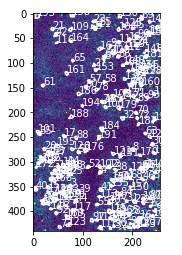

In [5]:
logging.info('Number of components: ' + str(cnm.estimates.A.shape[-1]))
Cn = cm.load(fnames[0], subindices=slice(0,500)).local_correlations(swap_dim=False)
cnm.estimates.plot_contours(img=Cn)

## View components

Now inspect the components extracted by OnACID. Note that if single pass was used then several components would be non-zero only for the part of the time interval indicating that they were detected online by OnACID.

Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [6]:
cnm.estimates.nb_view_components(img=Cn, denoised_color='red');

## Plot timing
The plot below shows the time spent on each part of the algorithm (motion correction, tracking of current components, detect new components, update shapes) for each frame. Note that if you displayed a movie while processing the data (`show_movie=True`) the time required to generate this movie will be included here.

(0, 140)

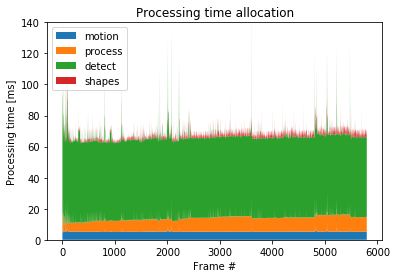

In [11]:
T_motion = 1e3*np.array(cnm.t_motion)
T_detect = 1e3*np.array(cnm.t_detect)
T_shapes = 1e3*np.array(cnm.t_shapes)
T_online = 1e3*np.array(cnm.t_online) - T_motion - T_detect - T_shapes
plt.figure()
plt.stackplot(np.arange(len(T_motion)), T_motion, T_online, T_detect, T_shapes)
plt.legend(labels=['motion', 'process', 'detect', 'shapes'], loc=2)
plt.title('Processing time allocation')
plt.xlabel('Frame #')
plt.ylabel('Processing time [ms]')
plt.ylim([0,140])